In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import sys
import os
import math
module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import static_token_div.tools.vocab_tools as vocab_tools

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


In [11]:
def read_corpus(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    tokens = text.strip().split()
    return tokens

In [12]:
vocab = vocab_tools.Vocab(emb_filename="embeddings-word2vecofficial.train.unk5.txt")

In [13]:
"Ã" in vocab.dico_voca.keys()

False

In [14]:
vocab.matrice.shape, len(vocab.dico_voca)

(torch.Size([2908, 100]), 2908)

In [15]:
def process_data_with_corpus(vocab, tokens, k: int):
    X_data, y_data = [], []
    indices = [vocab.get_word_index2(token) for token in tokens]

    for i in range(k, len(indices)):
        x_indices = indices[i - k:i]
        y_index = indices[i]

        embeddings = [vocab.get_emb_torch(idx) for idx in x_indices]
        x_embedded = torch.cat(embeddings)
        X_data.append(x_embedded)
        y_data.append(y_index)

    X_tensor = torch.stack(X_data)
    y_tensor = torch.tensor(y_data, dtype=torch.long)
    return X_tensor, y_tensor


In [118]:
k = 3
train_file_path = "../../resources/tlnl_tp1_data/alexandre_dumas/Le_comte_de_Monte_Cristo.train.unk5.tok"
test_file_path = "../../resources/tlnl_tp1_data/alexandre_dumas/Le_comte_de_Monte_Cristo.test.unk5.tok"

train_tokens = read_corpus(train_file_path)
test_tokens = read_corpus(test_file_path)

In [119]:
X_train, y_train = process_data_with_corpus(vocab, train_tokens, k=k)
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test, y_test = process_data_with_corpus(vocab, test_tokens, k=k)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [120]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([224535, 300]),
 torch.Size([224535]),
 torch.Size([24953, 300]),
 torch.Size([24953]))

In [185]:
class MLP(nn.Module):
    def __init__(self, k, vocab_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=k, hidden_size=30, num_layers=10, batch_first=True)
        self.fc1 = nn.Linear(30 * k, 32)
        self.fc2 = nn.Linear(32, vocab_size)

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.l2(x)
        return x


In [186]:
def train(model, criterion, optimizer, X_train, y_train, X_test, y_test, device, batch_size=64, nb_epoch=10):
    history = {
        "train_loss": [],
        "test_loss": []
    }

    num_samples = X_train.size(0)
    num_batches = (num_samples + batch_size - 1) // batch_size

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(nb_epoch):
        model.train()
        total_loss = 0.0

        for batch_X, batch_Y in train_dataloader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / num_batches
        history["train_loss"].append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch_X, batch_Y in test_loader:
                batch_X = batch_X.to(device)
                batch_Y = batch_Y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)

                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        history["test_loss"].append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{nb_epoch}], train loss: {avg_train_loss:.4f}, test loss: {avg_test_loss:.4f}')

    return history

In [187]:
def calculate_perplexity(model, data_loader, device):
    model.eval()  
    total_loss = 0.0
    total_words = 0

    criterion = nn.CrossEntropyLoss(reduction='sum')  

    with torch.no_grad():
        for batch_X, batch_Y in data_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)

            total_loss += loss.item()
            total_words += batch_Y.size(0)

    # Calcul de la perplexité
    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)  
    return perplexity




In [188]:
len(vocab.dico_voca)

2908

In [189]:
model = MLP(k=k, vocab_size=len(vocab.dico_voca)).to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
batch_size=64

In [190]:
history = train(model, criterion, optimizer, X_train, y_train, X_test, y_test, device, batch_size=batch_size, nb_epoch=20)

Epoch [1/20], train loss: 5.7397, test loss: 3.8585
Epoch [2/20], train loss: 4.9011, test loss: 3.7058
Epoch [3/20], train loss: 4.7316, test loss: 3.6111
Epoch [4/20], train loss: 4.6192, test loss: 3.5209
Epoch [5/20], train loss: 4.5424, test loss: 3.4549
Epoch [6/20], train loss: 4.4855, test loss: 3.4117
Epoch [7/20], train loss: 4.4420, test loss: 3.3736
Epoch [8/20], train loss: 4.4041, test loss: 3.3478
Epoch [9/20], train loss: 4.3700, test loss: 3.3174
Epoch [10/20], train loss: 4.3414, test loss: 3.3081
Epoch [11/20], train loss: 4.3212, test loss: 3.2780
Epoch [12/20], train loss: 4.2985, test loss: 3.2587
Epoch [13/20], train loss: 4.2828, test loss: 3.2426
Epoch [14/20], train loss: 4.2655, test loss: 3.2261
Epoch [15/20], train loss: 4.2527, test loss: 3.2225
Epoch [16/20], train loss: 4.2383, test loss: 3.1975
Epoch [17/20], train loss: 4.2284, test loss: 3.2008
Epoch [18/20], train loss: 4.2149, test loss: 3.1899
Epoch [19/20], train loss: 4.2086, test loss: 3.1886
Ep

(0.0, 5.0)

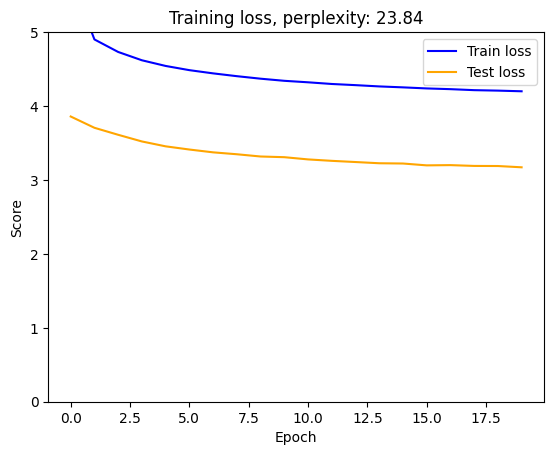

In [191]:

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
perplexity = calculate_perplexity(model, test_loader, device)

plt.plot(history["train_loss"], c="blue", label="Train loss")
plt.plot(history["test_loss"], c="orange", label="Test loss")
plt.ylabel("Score")
plt.xlabel("Epoch")
plt.title(f"Training loss, perplexity: {perplexity:.2f}")
plt.legend()
plt.ylim(0, 5)




In [192]:
def find_closest_word(output, embedding, vocab):
    current_ixd = 0
    dist = float("inf")
    for idx, line in enumerate(embedding):
        if torch.linalg.norm(line - output) < dist:
            current_ixd = idx
            dist = torch.linalg.norm(line - output)
    for word in vocab.dico_voca.keys():
        if vocab.dico_voca[word] == current_ixd:
            return word


def run(model, vocab, embedding, start_word):
    start_indices = [vocab.dico_voca[word] for word in start_word]
    embeddings = torch.concat([torch.Tensor(embedding[idx]) for idx in start_indices])
    output = model(embeddings)
    next_word = find_closest_word(output, embeddings, vocab)
    return next_word

In [194]:
startword = "le lendemain matin"
words = startword.split(" ")
for i in range(10):
    current_words = words[-3:]
    next_word = run(model, vocab, embedding=vocab.matrice, start_word=current_words)
    words.append(next_word)

print(words)

['le', 'lendemain', 'matin', 'elle', 'venait', 'celui', 'du', 'air', 'quand', 'cette', 'serait', 'monde', 'encore']
